# Tasks:

1. run decoding

2. summarizing decoding results

3. generate ensumble stats

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

18480


In [2]:
save_folder = r'\\mendel\Mendel_SSD4\Pu_Temp\20220109-CTP11-1000_CTP12-DNA_from_1230'

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5'][:15]
print(len(save_filenames))

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

15
Use segmentation_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220109-CTP11-1000_CTP12-DNA_from_1230\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220109-CTP11-1000_CTP12-DNA_from_1230\CandSpots


## load codebook

In [3]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910,chr,chr_order
0,1:3740000-3760000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:6240000-6260000,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1:8740000-8760000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,1:11240000-11260000,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,1:13740000-13760000,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,X:161240000-161260000,1057,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,X,52
984,X:163740000-163760000,1058,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,X,53
985,X:166240000-166260000,1059,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,X,54
986,X:168740000-168760000,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,55


### generate necessary variables for plotting

In [5]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

## find spots

In [6]:
spot_filenames = [os.path.join(cand_spot_folder, _fl) for _fl in os.listdir(cand_spot_folder)]
print(len(spot_filenames))

2307


In [56]:
cand_spot_folder

'\\\\mendel\\Mendel_SSD4\\Pu_Temp\\20220109-CTP11-1000_CTP12-DNA_from_1230\\CandSpots'

In [57]:
%%time

intensity_th = 1000

combo_ids = np.load(os.path.join(save_folder, 'combo_ids.npy'))
combo_channels = np.load(os.path.join(save_folder, 'combo_channels.npy'))
id_2_channel = {_id:_ch for _id,_ch in zip(combo_ids, combo_channels)}


cand_spot_filenames = [os.path.join(cand_spot_folder, _fl) for _fl in os.listdir(cand_spot_folder)
                       if 'CandSpots' in _fl]
print(len(spot_filenames))
# load 
cand_spot_dicts = []
for _cand_spot_filename in cand_spot_filenames[:]:
    cand_spot_dicts.append(pickle.load(open(_cand_spot_filename, 'rb')))
    
# get stats for spots in each bit
_bit_2_intensities = {_b:[] for _b in combo_ids}
for _spot_dict in cand_spot_dicts:
    for _bit, _spots in _spot_dict.items():
        #print(_bit)
        if len(_spots) > 0:
            _bit_2_intensities[_bit].append(_spots[:,0])

_bit_2_intensities = {_b:np.concatenate(_v) for _b,_v in _bit_2_intensities.items()}
# get median as normalization 
bit_2_median_ints = {_b:np.median(_ints[_ints>intensity_th]) for _b, _ints in _bit_2_intensities.items()}

# normalize
normed_cand_spot_dicts = []

for _dict in cand_spot_dicts:
    _normed_dict = {}
    for _bit, _spots in _dict.items():
        _new_spots = copy.copy(_spots[_spots[:,0] > intensity_th])
        _new_spots[:,0] *= 1 / bit_2_median_ints[_bit]
        _normed_dict[_bit] = _new_spots
    
    # append
    normed_cand_spot_dicts.append(_normed_dict)


2307
Wall time: 49.6 s


In [58]:
if not os.path.exists(os.path.join(cand_spot_folder, 'normalized')):
    os.makedirs(os.path.join(cand_spot_folder, 'normalized') )
    print(os.path.join(cand_spot_folder, 'normalized') )
    
for _cand_spot_filename, _dict in zip(cand_spot_filenames, normed_cand_spot_dicts):
    _save_filename = os.path.join(cand_spot_folder, 'normalized', 
                                  os.path.basename(_cand_spot_filename).replace('CandSpots', 'NormedCandSpots'))
    pickle.dump(_dict, open(_save_filename, 'wb'))
    

\\mendel\Mendel_SSD4\Pu_Temp\20220109-CTP11-1000_CTP12-DNA_from_1230\CandSpots\normalized


In [107]:
len(list(_bit_2_intensities.values()))

99

<IPython.core.display.Javascript object>


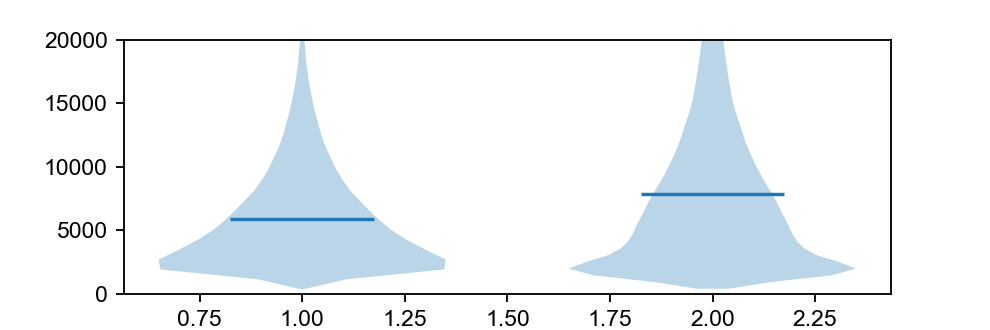

In [117]:
fig, ax = plt.subplots(figsize=(6,2), dpi=150)

ax.violinplot(list(_bit_2_intensities.values())[:2],
              list(_bit_2_intensities.keys())[:2],
              widths=0.7,
              showmeans=True,showextrema=False,
             )

ax.set_ylim([0, 20000])

fig.show()

In [177]:
plt.figure()
plt.plot(list(bit_2_median_ints.values()))
plt.xlabel('Bit')
plt.ylabel('Median intensity')
plt.ylim([0,8000])
plt.show()

<IPython.core.display.Javascript object>

In [75]:
cell_spots_counts = []
for _dict in normed_cand_spot_dicts:
    _counts = []
    for _bit in combo_ids:
        if _bit in _dict:
            _counts.append(len(_dict[_bit]))
        else:
            _counts.append(0)
    # append count
    cell_spots_counts.append(_counts)
cell_spots_counts = np.array(cell_spots_counts)

In [72]:
cell_spots_counts = []
for _dict in cand_spot_dicts:
    _counts = []
    for _bit in combo_ids:
        if _bit in _dict:
            _counts.append(len(_dict[_bit]))
        else:
            _counts.append(0)
    # append count
    cell_spots_counts.append(_counts)
cell_spots_counts = np.array(cell_spots_counts)

<IPython.core.display.Javascript object>


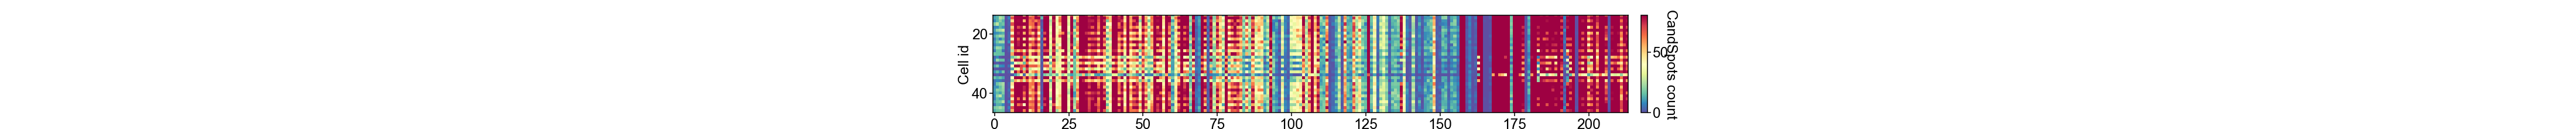

In [173]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(20,1), dpi=200, )

_pf = ax.imshow(cell_spots_counts.transpose(), cmap='Spectral_r', vmin=0, vmax=80)

ax.tick_params('both', labelsize=8, 
                width=0.5, length=2,
                pad=1, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(0.5) for i in ax.spines.items()]

ax.set_xlabel('Bit', fontsize=8, labelpad=1)

ax.set_ylabel('Cell id', fontsize=8, labelpad=0)
# locate ax
divider = make_axes_locatable(ax)
# colorbar ax
cax = divider.append_axes('right', size='1%', pad="2%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax, )

cbar.ax.tick_params('both', labelsize=8, 
                width=0.5, length=2,
                pad=1, labelleft=False) # remove bottom ticklabels for ax
cbar.outline.set_linewidth(0.5)
cbar.set_label('CandSpots count', 
               fontsize=8, labelpad=5, rotation=270)

#fig.savefig(os.path.join(figure_folder, dna_fov.fov_name.replace('.dax', f'_SpotCounts_th-{int_th}.png')))
#fig.show()
    

In [71]:
980 * 3 * 2 / 99

59.39393939393939

In [26]:
for _b in _bit_2_intensities:
    print(_b, np.median(_bit_2_intensities[_b]))

1 4712.136
2 6030.2446
3 4236.151
4 6689.0625
5 4135.773
6 6765.5195
7 4191.3975
8 6269.465
9 4079.6687
10 6668.303
11 3797.8633
12 6539.706
13 3826.9966
14 6264.909
15 3896.0034
16 6099.174
17 3652.9502
18 6048.5947
19 3744.7888
20 6526.5146
21 3518.7427
22 6111.0244
23 3627.4065
24 6198.3354
25 3633.9373
26 6030.9355
27 3690.8604
28 5624.4316
29 3472.158
30 5733.3096
31 2040.265
32 5178.037
33 2070.7144
34 5358.679
35 1792.1404
36 2432.8037
37 3726.9712
38 6417.3384
39 4376.5986
40 6254.4253
41 4108.2305
42 5743.4717
43 4123.556
44 5709.63
45 1287.8433
46 6371.5264
47 4070.31
48 5475.5654
49 1469.5999
50 3489.892
51 4187.9517
52 6102.0435
53 3758.1685
54 5872.5586
55 4176.1875
56 6022.3945
57 4161.1436
58 6326.4443
59 4233.89
60 5796.871
61 4233.2837
62 5526.213
63 3316.628
64 5495.905
65 3674.1926
66 5340.049
67 3662.4553
68 5706.2686
69 3693.9534
70 5220.113
71 4061.639
72 5754.8755
73 3713.365
74 5741.6943
75 3382.7568
76 6213.6147
77 3869.12
78 4963.54
79 3197.3652
80 5641.8003
8

## prepare decode inputs

In [6]:
print(save_folder)

\\mendel\Mendel_SSD4\Pu_Temp\20220109-CTP11-1000_CTP12-DNA_from_1230


In [156]:
from ImageAnalysis3.classes import decode
from ImageAnalysis3.classes.preprocess import Spots3D
reload(decode)

combo_ids = np.load(os.path.join(save_folder, 'combo_ids.npy'))
combo_channels = np.load(os.path.join(save_folder, 'combo_channels.npy'))
id_2_channel = {_id:_ch for _id,_ch in zip(combo_ids, combo_channels)}
pair_search_radius = 300
pixel_sizes = [250,108,108]
debug = True

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
print(decoder_folder)

\\mendel\Mendel_SSD4\Pu_Temp\20220109-CTP11-1000_CTP12-DNA_from_1230\Decoder\v7


In [157]:
# replace cand_spot_filenames
normed_cand_spot_filenames = [os.path.join(cand_spot_folder, 'normalized', _fl) 
                              for _fl in os.listdir(cand_spot_folder) if 'CandSpots' in _fl]
print(len(normed_cand_spot_filenames))

2306


In [158]:
%%time
# old version
from ImageAnalysis3.classes import decode
reload(decode)
overwrite = True

# create decoder filenames
decoder_filenames = [os.path.join(decoder_folder,
                                 os.path.basename(_cand_spot_filename).replace('CandSpots', 'Decoder') )
                     for _cand_spot_filename in normed_cand_spot_filenames]
    
decode_args = [(_fl, codebook_df, _decoder_fl, 
                False, True, id_2_channel,
                pixel_sizes, 2, 0.5, 
                pair_search_radius, -1, 1, 5, 0, -25, False, overwrite, True, False) 
               for _fl, _decoder_fl in zip(spot_filenames, decoder_filenames)
               #if not os.path.exists(_fl.replace('CandSpots', 'Decoder'))
              ][500:1100]
print(len(decode_args))

600
Wall time: 66 ms


- 13069 pairs kept given search radius 300 nm.
- search spot_groups given search radius 300 nm, max_usage=1
-- select unique pairs.


54it [00:00, 529.02it/s]

-- upgrade pairs.


3103it [00:06, 511.16it/s]


- 3103 spot_groups detected
- split found tuples into chromosomes. 
- generate randomized spot pairs 
- generate chr_2_kdtree. 
-- seeding chr:1 with 77 regions with 243 spot_groups
- diff in iter-0: 0.4733
- diff in iter-1: 0.0617
- diff in iter-2: 0.0329
- diff in iter-3: 0.0165
- diff in iter-4: 0.0041
- diff in iter-5: 0.0041
- diff in iter-6: 0.0123
- diff in iter-7: 0.0000
-- seeding chr:10 with 51 regions with 153 spot_groups
- diff in iter-0: 0.4444
- diff in iter-1: 0.0719
- diff in iter-2: 0.0392
- diff in iter-3: 0.0719
- diff in iter-4: 0.0915
- diff in iter-5: 0.0327
- diff in iter-6: 0.0000
-- seeding chr:11 with 48 regions with 164 spot_groups
- diff in iter-0: 0.4390
- diff in iter-1: 0.0976
- diff in iter-2: 0.0549
- diff in iter-3: 0.0366
- diff in iter-4: 0.0305
- diff in iter-5: 0.0427
- diff in iter-6: 0.0366
- diff in iter-7: 0.0183
- diff in iter-8: 0.0244
- diff in iter-9: 0.0366
- diff in iter-10: 0.0366
- diff in iter-11: 0.0488
- diff in iter-12: 0.0488
- dif

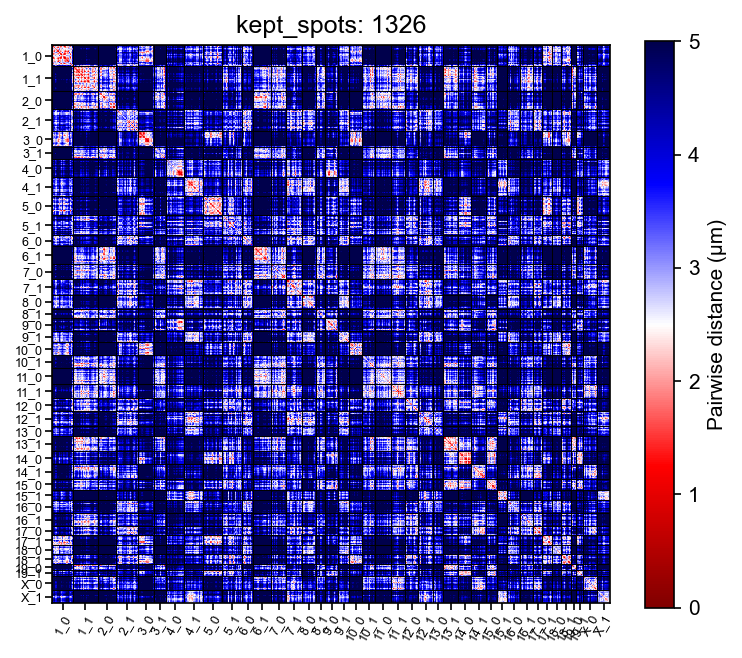

In [174]:
# test run one cell
%matplotlib inline
reload(decode)
decoder = decode.batch_decode_DNA(*decode_args[11])

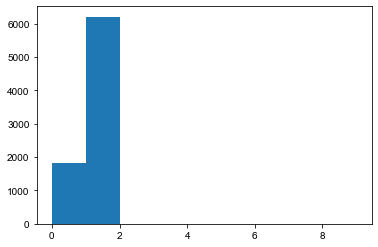

In [160]:
plt.figure()
plt.hist(decoder.spot_usage, bins=np.arange(10))
plt.show()
#plt.hist(decoder.spot_usage)

<IPython.core.display.Javascript object>


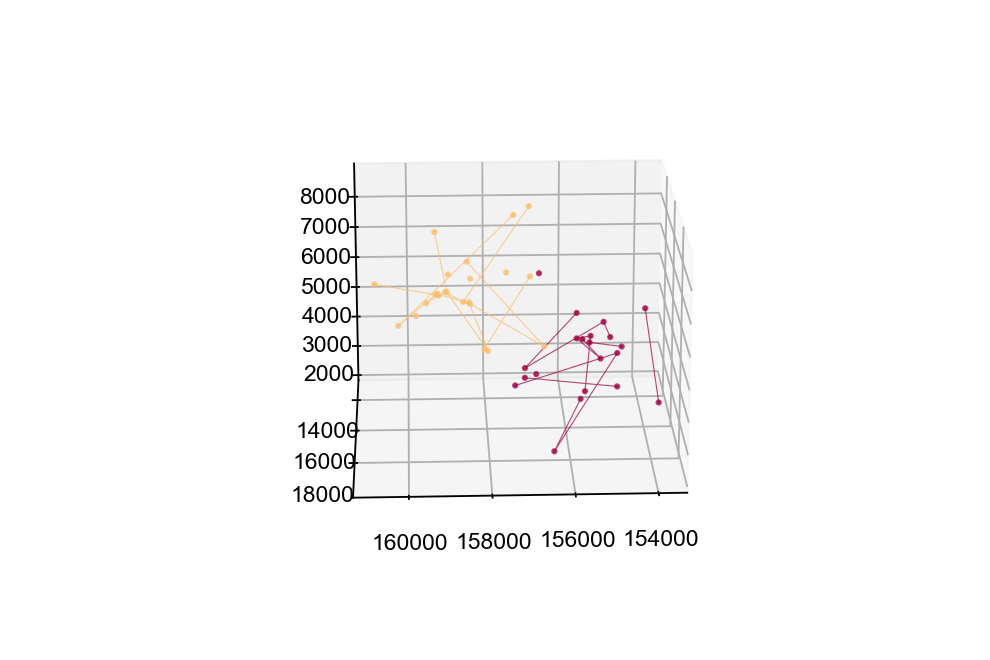

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [172]:
%matplotlib notebook
%matplotlib notebook

def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')

_zxys_list = decoder.chr_2_zxys_list['17']

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               cmap=Spectral, 
               c=Spectral(_ichr/(len(_zxys_list)+1)),
               #c=homolog_labels,
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
fig.show()

In [137]:
%%time
# old version
import multiprocessing as mp

with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

Wall time: 30min 49s


## load decode results

In [138]:
#decoder_folder = os.path.join(save_folder, 'Decoder')
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in os.listdir(decoder_folder) 
                if _fl.split(os.path.extsep)[-1]=='pkl']
print(decoder_folder, len(decoder_filenames))

\\mendel\Mendel_SSD4\Pu_Temp\20220109-CTP11-1000_CTP12-DNA_from_1230\Decoder\v6 420


In [139]:
%%time
import multiprocessing as mp
load_args = [(_fl, 'chr_2_zxys_list') for _fl in decoder_filenames]
print(len(load_args))
with mp.Pool(44) as load_pool:
    all_chr_2_zxys_list = load_pool.starmap(decode.batch_load_attr, 
                                            load_args, chunksize=1)
    load_pool.close()
    load_pool.join()
    load_pool.terminate()

# summarize
decode_filenames = [_fl for _fl,_item in zip(decoder_filenames, all_chr_2_zxys_list) if _item is not None]
all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
print(len(all_chr_2_zxys_list))

420
420
Wall time: 30.2 s


In [140]:
%%time
import multiprocessing as mp
summary_args = [(_item, codebook_df) for _item in all_chr_2_zxys_list ]

print(len(summary_args))

with mp.Pool(44) as summary_pool: 
    all_zxys_list = summary_pool.starmap(decode.DNA_Merfish_Decoder.summarize_zxys_by_regions, 
                                         summary_args, chunksize=1)
    summary_pool.close()
    summary_pool.join()
    summary_pool.terminate()

420
Wall time: 59.3 s


## save

In [141]:
# save decode results
decode_save_dict = {
    'zxys':[],
    'fov_id':[],
    'cell_id':[],
}
for _zxys_list, _decoder_filename in zip(all_zxys_list, decoder_filenames):
    _fov_id = int(os.path.basename(_decoder_filename).split('zscan_')[1].split('_')[0])
    _cell_id = int(os.path.basename(_decoder_filename).split('Cell-')[1].split('_')[0])
    # append
    for _zxys in _zxys_list:
        decode_save_dict['zxys'].append(_zxys)
        decode_save_dict['fov_id'].append(_fov_id)
        decode_save_dict['cell_id'].append(_cell_id)

# save
decode_save_filename = os.path.join(decoder_folder, f"decode_zxys_fov_{min(decode_save_dict['fov_id'])}-{max(decode_save_dict['fov_id'])}.pkl")
print(f"Save decode_save_dict to file: {decode_save_filename}")
pickle.dump(decode_save_dict, open(decode_save_filename, 'wb'))

Save decode_save_dict to file: \\mendel\Mendel_SSD4\Pu_Temp\20220109-CTP11-1000_CTP12-DNA_from_1230\Decoder\v6\decode_zxys_fov_3-8.pkl


In [142]:
decode_save_dict = pickle.load(open(r'\\mendel\Mendel_SSD4\Pu_Temp\20220109-CTP11-1000_CTP12-DNA_from_1230\Decoder\v1\decode_zxys_fov_0-19.pkl', 'rb'))

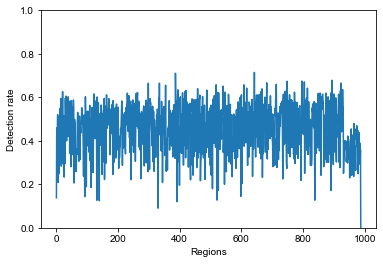

In [143]:
all_zxys = np.array(decode_save_dict['zxys'])
loss_rates = np.mean(np.isnan(all_zxys).any(2), axis=0)
plt.figure()
plt.plot(1-loss_rates)
plt.ylim([0,1])
plt.xlabel('Regions')
plt.ylabel('Detection rate')
plt.show()

In [144]:
from tqdm import tqdm

In [145]:
region_usage_list = []
# check inds usage
for _decoder_filename in tqdm(decoder_filenames[:100]):
    _decoder = pickle.load(open(_decoder_filename, 'rb'))
    _region_usage = np.zeros(codebook_df.shape[0])
    for _g in _decoder.spot_groups:
        _g.spots_inds
        
        _rind = codebook_df[codebook_df['id']==_g.tuple_id].index[0]
        _region_usage[_rind] += 1
    # append
    region_usage_list.append(_region_usage)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [04:58<00:00,  2.99s/it]


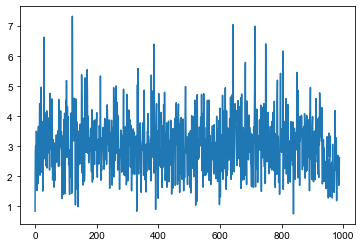

In [146]:
plt.figure()
plt.plot(np.mean(region_usage_list, axis=0), )
plt.show()

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


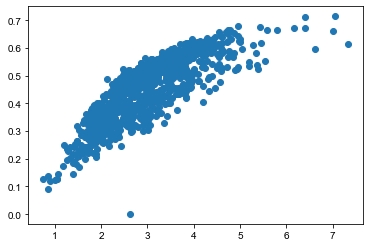

In [147]:
fig,ax = plt.subplots()
ax.scatter(np.mean(region_usage_list, axis=0), 1-loss_rates, )
fig.show()

In [45]:
all_zxys_list.shape

AttributeError: 'list' object has no attribute 'shape'

## Median distance map

In [148]:
%%time
from scipy.spatial.distance import cdist,pdist,squareform
from tqdm import tqdm

#all_zxys_list = np.concatenate(all_zxys_list)
all_zxys_list = np.array(decode_save_dict['zxys'])

all_distmaps = [squareform(pdist(_zxys)) for _zxys in tqdm(all_zxys_list)]

from ImageAnalysis3.classes import postanalysis
median_distmap = postanalysis.parallel_reduce_matrix(all_distmaps, function='nanmedian', axis=0,
                                                     num_threads=44)

100%|███████████████████████████████████████████████████████████████████████████| 3108/3108 [01:12<00:00, 42.66it/s]


Wall time: 4min 19s


In [149]:
%%time
all_contactmaps = np.array(all_distmaps) <= 0.5

contactmap = postanalysis.parallel_reduce_matrix(all_contactmaps, function='nanmean', axis=0,
                                                     num_threads=44)

Wall time: 1min 43s


In [150]:
save_figure = True
#figure_folder = os.path.join(save_folder, 'Figures_final')
figure_folder = os.path.join(decoder_folder, 'Figures_final')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")

Create figure_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220109-CTP11-1000_CTP12-DNA_from_1230\Decoder\v6\Figures_final


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  
E:\Users\puzheng\Documents\ImageAnalysis3\figure_tools\distmap.py:39: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmin=min(color_limits), vmax=max(color_limits), **imshow_kwargs)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


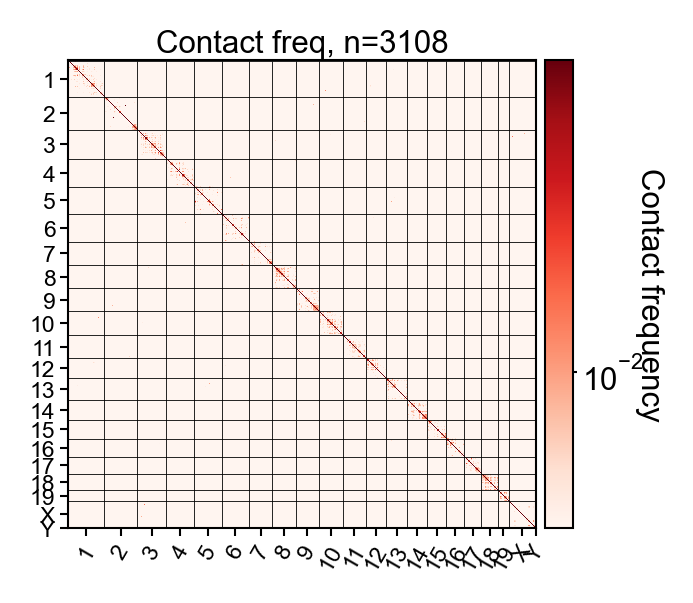

In [175]:
from matplotlib.colors import LogNorm
from matplotlib import cm

contact_limits = [0.005, 0.04]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = cm.get_cmap('Reds')
contact_cmap.set_bad(color=[0.,0.,0.,1])

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(
    contactmap, 
    cmap=contact_cmap,
    color_limits=contact_limits,
    color_norm=contact_norm,
    colorbar_labels='Contact frequency',
    ax=ax,
)

ax.set_title(f'Contact freq, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_contact_map.png'), transparent=True)
fig.show()


<IPython.core.display.Javascript object>


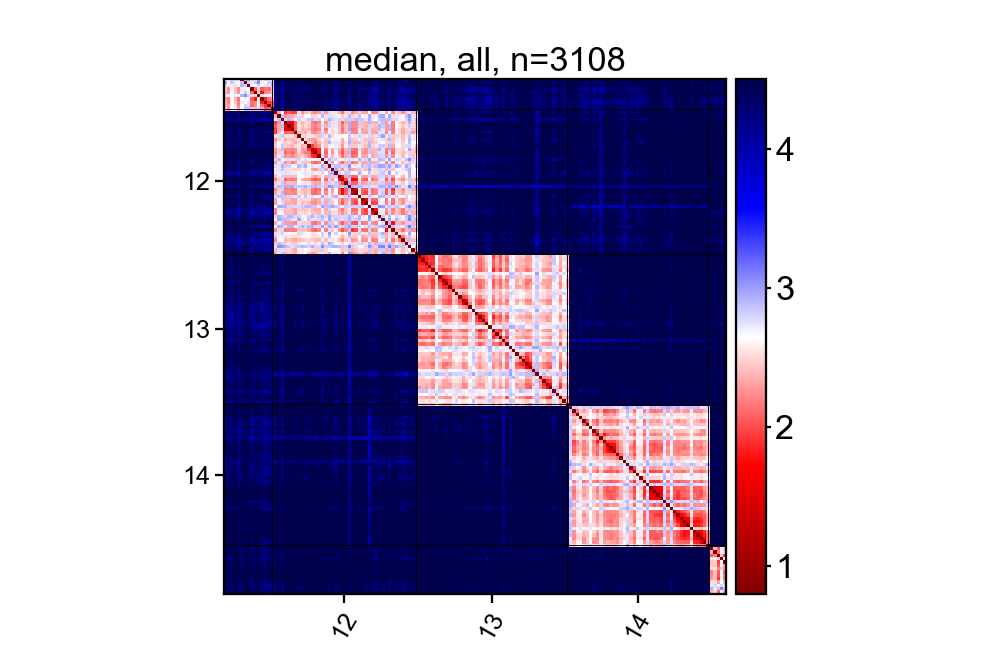

In [176]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(median_distmap, color_limits=[0.8,4.5],
                                          ax=ax,
                                          )
ax.set_title(f'median, all, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_median_distmap.png'), transparent=True)
fig.show()